In [1]:
! mkdir chest_dataset
! unzip /content/drive/MyDrive/COVID-19_Radiography_Database_old.zip -d chest_dataset

Streaming output truncated to the last 5000 lines.
  inflating: chest_dataset/COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: chest_dataset/COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: chest_dataset/COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: chest_dataset/COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: chest_dataset/COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: chest_dataset/COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: chest_dataset/COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: chest_dataset/COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: chest_dataset/COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: chest_dataset/COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: chest_dataset/COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: chest_dataset/COVID-19_Radiography_Dataset/Nor

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import multilabel_confusion_matrix
import tqdm
import os 
import pandas as pd
import glob
import shutil


In [3]:
def generate_dataset(path, size = 224,batch_size = 32): 
    image_generator = ImageDataGenerator(
        samplewise_center=True, #Set each sample mean to 0.
        samplewise_std_normalization= True, # Divide each input by its standard deviation]
        #rescale=1./255,
        validation_split = 0.3
    )

    #create training and testing datasets
    training_data = image_generator.flow_from_directory(directory = 
        path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,
                                                     
        shuffle=True,
        seed=123,
        subset="training"
    )

    #create training and testing datasets
    validation_data = image_generator.flow_from_directory(directory = 
        path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="validation"
    )

    return training_data, validation_data

def get_filepath_from_image_generator(gen):
    if gen.batch_index <=0:
        raise ValueError('Use iterator to move to batch_index > 0')
    left = (gen.batch_index - 1) * gen.batch_size
    right = left + gen.batch_size if left >= 0 else None
    indices = gen.index_array[left:right]
    filenames = [gen.filenames[i] for i in indices]
    return indices, filenames

In [4]:
path = '/content/chest_dataset/COVID-19_Radiography_Dataset/'
train_data, val_data = generate_dataset(
    path, size = 128,batch_size = 32)

Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.


In [5]:
class_names = train_data.class_indices
print(class_names)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [6]:
classes = list(class_names.keys())
print(classes)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [7]:
images,labels = next(train_data)
indices,image_path = get_filepath_from_image_generator(train_data)
labels = np.argmax(labels, axis=1)
class_dict = train_data.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names=[]
for i in labels:
    y_names.append(class_dict_inv[i])

<ipython-input-8-d58ed67d4c70>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2, 4, i+1)
<ipython-input-8-d58ed67d4c70>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(2,4,i+1+4)


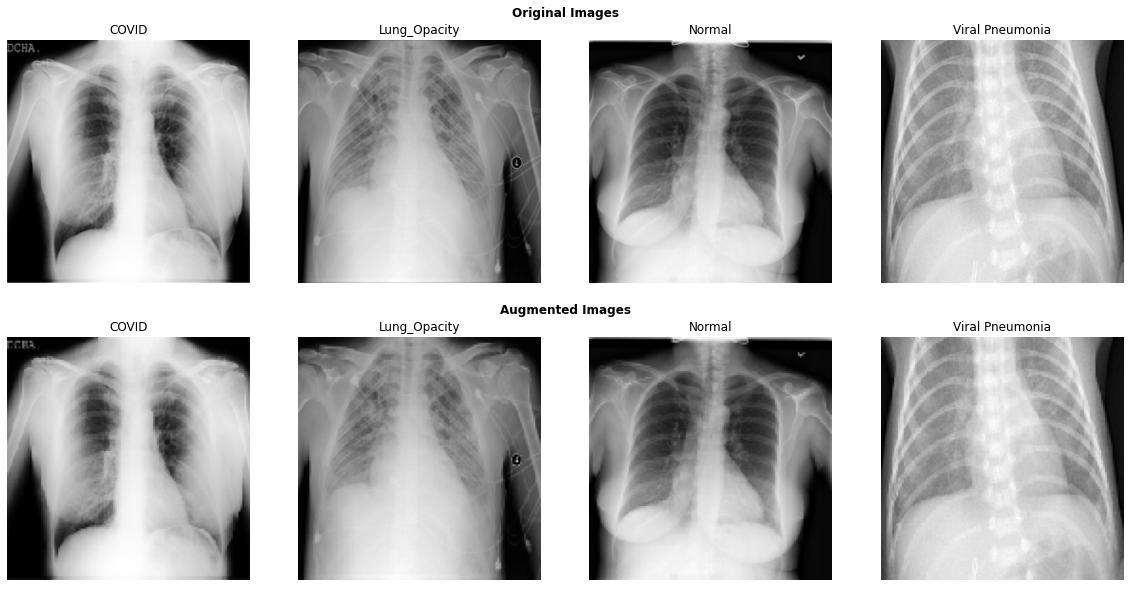

In [8]:
#Lets visualize the augmented images
fig, big_axes = plt.subplots( figsize=(20, 10) , nrows=2, ncols=1, sharey=True) 
titles = ['Original Images','Augmented Images']
for title, big_ax in zip(titles, big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on = False
    big_ax.axis('off')
for image in images:
    j  = 0
    for i in range(4):
        ax = fig.add_subplot(2, 4, i+1)
        ax1 = fig.add_subplot(2,4,i+1+4)
        for k in range(len(labels)):
            if labels[k] == j:
                og = cv2.imread(path+image_path[k],0)
                ax.imshow(og,cmap = 'gray')
                ax.set_title(classes[i])
                ax.axis("off")
                ax1.imshow(images[k][:,:,0],cmap = 'gray')
                ax1.set_title(classes[i])
                ax1.axis("off")
                break
        j = j+1
plt.show()

In [9]:
# Investigating single original image
def plot_single_image(raw_image,title):
    plt.imshow(raw_image, cmap='gray')
    plt.colorbar()
    plt.title(title)
    print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
    print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
    print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")
    plt.show()

The dimensions of the image are 299 pixels width and 299 pixels height, one single color channel
The maximum pixel value is 222.0000 and the minimum is 0.0000
The mean value of the pixels is 149.5784 and the standard deviation is 49.4926


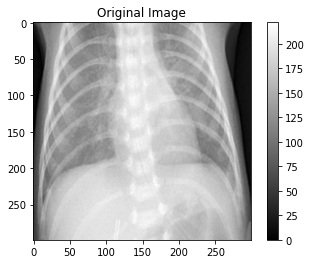

The dimensions of the image are 128 pixels width and 128 pixels height, one single color channel
The maximum pixel value is 1.4452 and the minimum is -3.0251
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


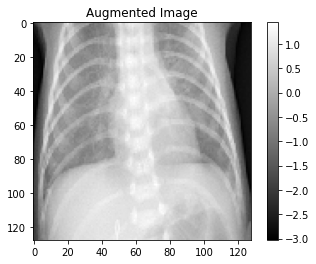

In [10]:
plt.figure(1)
image = cv2.imread(path+image_path[k],0)
plot_single_image(image,'Original Image')
plt.figure(2)
plot_single_image(images[k][:,:,0],'Augmented Image')

In [11]:
all_items,dirs,files = next(os.walk(path))

In [12]:
num_image_classes = []
for i in range(len(dirs)):
    i_images =len(os.listdir(os.path.join(path,dirs[i])))
    num_image_classes.append(i_images)
df_data = {'class': dirs,'counts': num_image_classes}
classes_df = pd.DataFrame(df_data)    

In [13]:
num_classes = len(dirs)

### The graph below shows us the total images present in different classes. We have four class - COVID, Normal, Lung_Opacity and Viral Pneumonia. 

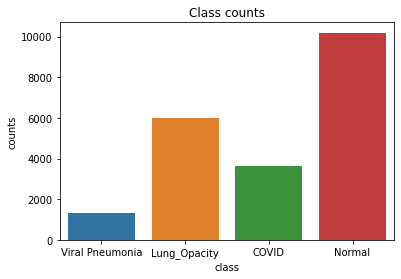

In [14]:
sns.barplot(x = 'class', y = 'counts',data = classes_df)
plt.title('Class counts')
plt.show()

In [15]:
def plot_accuracy_graph(n_epochs_model, r_model):
  range_epoch = range(1,n_epochs_model+1)
  fig, ax = plt.subplots(1,1,figsize=(8,5))
  ax.plot(range_epoch,r_model.history['accuracy'],'r',label = 'Training Accuracy')
  ax.plot(range_epoch,r_model.history['val_accuracy'],'y',label = 'Validation Accuracy')
  ax.set_title('Training and Validation accuracy')
  ax.set_xlabel('Epoch', fontsize = 4)
  ax.set_ylabel('Accuracy', fontsize = 4)
  ax.legend()
  ax.grid(color='gray', linestyle='--')
  plt.show()

In [16]:
# Training and Validation Loss
def plot_loss_graph(n_epochs_model, r_model):
  range_epoch = range(1,n_epochs_model+1)
  fig, ax = plt.subplots(1,1,figsize=(8,5))
  ax.plot(range_epoch,r_model.history['loss'],'b',label = 'Training Loss')
  ax.plot(range_epoch,r_model.history['val_loss'],'g',label = 'Validation Loss')
  ax.set_title('Training and Validation loss')
  ax.set_xlabel('Epoch', fontsize = 20)
  ax.set_ylabel('Loss', fontsize = 20)
  ax.legend()
  ax.grid(color='gray', linestyle='--')

# Basic CNN model
#### Here we are building a basic CNN model with 5 layers and having the activation function as relu for the first 4 layers and the last layer has softmax as the activation function.

#### We are using early stop function and are keeping the patience as 5. After 5 epochs if there is no improvement in the validation loss, we stop our training.

In [17]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

def cnn_model(train_data,test_data, epochs,size):
    print("----Building the model----")
    i = Input(shape=(size,size,1)) #defining input
    x = BatchNormalization()(i)
    x = Conv2D(32,3, activation= 'relu')(i) #adding convolution layers
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(4, activation= 'softmax')(x)

    model_cnn = Model(i,x)
    model_cnn.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model_cnn.compile(optimizer= Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('cnn_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model_cnn.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model_cnn.evaluate(train_data))
    print("Test score:", model_cnn.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model_cnn,n_epochs 

In [18]:
epochs = 20
r_cnn,model_cnn,n_epochs_cnn = cnn_model(train_data, val_data,epochs,128)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                              

## Training and Validation Accuracy/Loss for Basic CNN model.



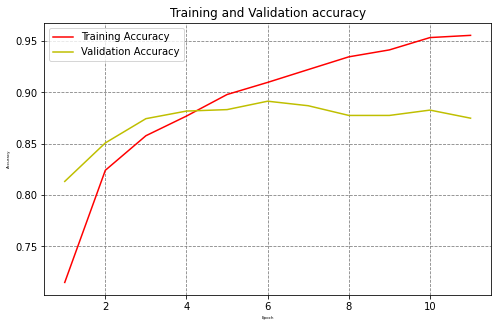

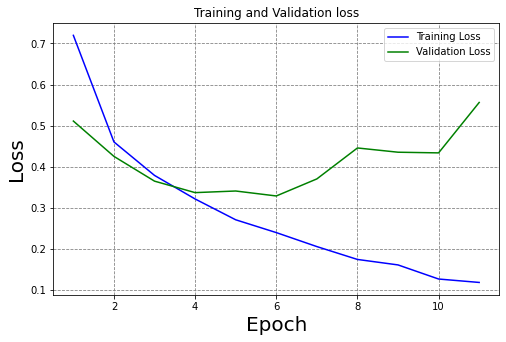

In [19]:
plot_accuracy_graph(n_epochs_cnn,r_cnn)
plot_loss_graph(n_epochs_cnn,r_cnn)

In [20]:
# printing model accuracy for train and test data

train_eval = model_cnn.evaluate(train_data)
print(f"Basic CNN Train Accuracy : {train_eval[1] * 100:.2f}%")

test_eval = model_cnn.evaluate(val_data)
print(f"Basic CNN Test Accuracy :{test_eval[1] * 100:.2f}%")


464/464 [==============================] - 33s 71ms/step - loss: 0.1538 - accuracy: 0.9482
Basic CNN Train Accuracy : 94.82%
199/199 [==============================] - 14s 71ms/step - loss: 0.3288 - accuracy: 0.8914
Basic CNN Test Accuracy :89.14%


In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve

def extract_from_generator(data):
    data.reset()
    X, y = next(data)
    for i in tqdm.tqdm(range(int(data.n/data.batch_size)-1)): 
        img, label = next(data)
        X = np.append(X, img, axis=0 )
        y = np.append(y, label, axis=0)
    return X,y

X_train,y_train = extract_from_generator(train_data)
X_test,y_test = extract_from_generator(val_data)

# y_pred  = np.round(model_cnn.predict(X_test))

100%|██████████| 197/197 [00:24<00:00,  8.18it/s]


In [22]:
y_pred  = np.round(model_cnn.predict(X_test))
y_test_c = np.argmax(y_test,axis = 1) 
y_pred_c = np.argmax(y_pred,axis = 1)

print(classification_report(y_test,y_pred))

198/198 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.93      0.84      0.89      1081
           1       0.85      0.86      0.86      1800
           2       0.91      0.91      0.91      3052
           3       0.91      0.93      0.92       403

   micro avg       0.90      0.89      0.89      6336
   macro avg       0.90      0.89      0.89      6336
weighted avg       0.90      0.89      0.89      6336
 samples avg       0.89      0.89      0.89      6336



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Resnet50 model

### New Section

In [23]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import RMSprop

def resnet_model(train_data,test_data, epochs,size):
#Building the model using Keras functional API
    print("----Building the model----")
    
    base_model = ResNet50(input_shape= (size,size,1), weights = None, include_top=False)
#     base_model.trainable=False #freezing the layer

    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out=Dense(4,activation='softmax')(x)

    model_resnet=Model(inputs=base_model.input,outputs=out) 
    model_resnet.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model_resnet.compile(optimizer= Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('resnet_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    res = model_resnet.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model_resnet.evaluate(train_data))
    print("Test score:", model_resnet.evaluate(val_data))
    n_epochs = len(res.history['loss'])
    
    return res,model_resnet,n_epochs

In [24]:
epochs = 25
r_resnet,model_resnet,n_epochs_resnet = resnet_model(train_data, val_data,epochs,128)

----Building the model----
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         

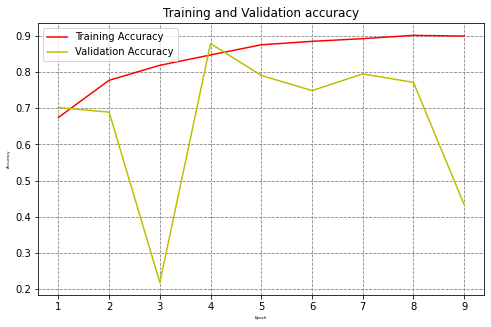

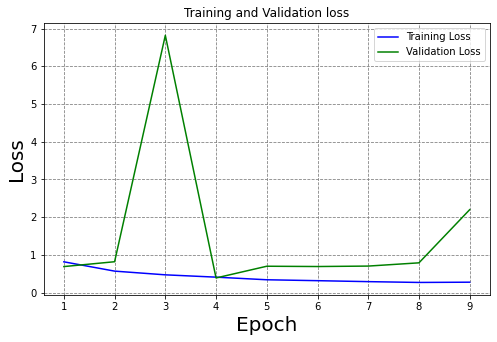

In [25]:
plot_accuracy_graph(n_epochs_resnet,r_resnet)
plot_loss_graph(n_epochs_resnet,r_resnet)

In [26]:
# printing model accuracy for train and test data
test_evaluation = model_resnet.evaluate(val_data)
print(f"Test Accuracy using ResNet50: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model_resnet.evaluate(train_data)
print(f"Train Accuracy using ResNet50: {train_evaluation[1] * 100:.2f}%")

199/199 [==============================] - 14s 73ms/step - loss: 0.3860 - accuracy: 0.8785
Test Accuracy using ResNet50: 87.85%
464/464 [==============================] - 34s 73ms/step - loss: 0.3327 - accuracy: 0.8852
Train Accuracy using ResNet50: 88.52%


100%|██████████| 197/197 [00:23<00:00,  8.48it/s]


198/198 [==============================] - 3s 10ms/step
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1083
           1       0.87      0.84      0.85      1798
           2       0.89      0.94      0.91      3054
           3       0.90      0.92      0.91       401

   micro avg       0.89      0.87      0.88      6336
   macro avg       0.89      0.86      0.87      6336
weighted avg       0.89      0.87      0.88      6336
 samples avg       0.87      0.87      0.87      6336



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


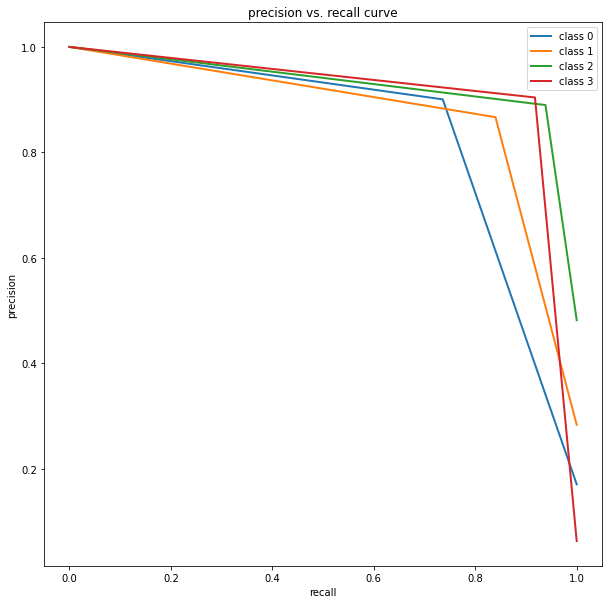

In [27]:
X_train,y_train = extract_from_generator(train_data)
X_test,y_test = extract_from_generator(val_data)
y_pred  = np.round(model_resnet.predict(X_test))
y_test_c = np.argmax(y_test,axis = 1) 
y_pred_c = np.argmax(y_pred,axis = 1)

print(classification_report(y_test,y_pred))

plt.figure(figsize = (10,10))
precision = dict()
recall = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()


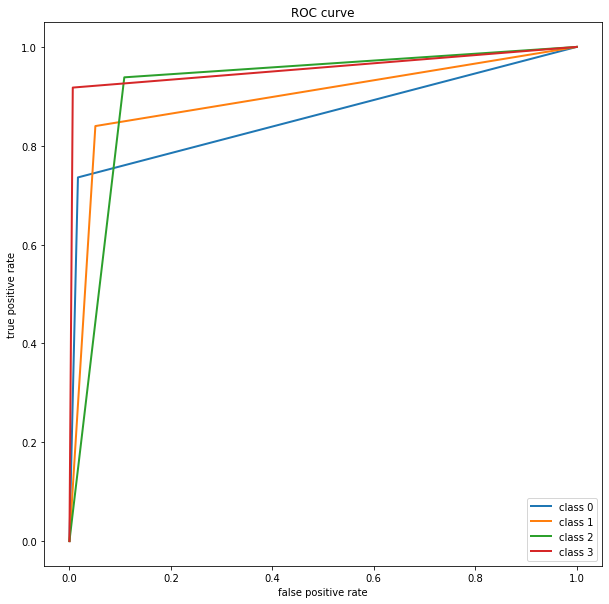

In [28]:
plt.figure(figsize = (10,10))
fpr = dict()
tpr = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_pred[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

# VGG16 Model

In [29]:
# from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import RMSprop


def vgg_model(train_data,test_data, epochs,size):
#Building the model using Keras functional API
    print("----Building the model----")
    
    base_model = VGG16(input_shape= (size,size,1), weights = None, include_top=False)
#     base_model.trainable=False #freezing the layer


    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out=Dense(4,activation='softmax')(x)

    model_vgg=Model(inputs=base_model.input,outputs=out) 
    model_vgg.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model_vgg.compile(optimizer= RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('vgg_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    res = model_vgg.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model_vgg.evaluate(train_data))
    print("Test score:", model_vgg.evaluate(val_data))
    n_epochs = len(res.history['loss'])
    
    return res,model_vgg,n_epochs

In [30]:
epochs = 20
r_vgg,model_vgg,n_epochs_vgg = vgg_model(train_data, val_data,epochs,128)

----Building the model----
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (No

In [31]:
# printing model accuracy for train and test data
test_evaluation = model_vgg.evaluate(val_data)
print(f"Test Accuracy using ResNet50: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model_vgg.evaluate(train_data)
print(f"Train Accuracy using ResNet50: {train_evaluation[1] * 100:.2f}%")

199/199 [==============================] - 14s 71ms/step - loss: 0.2551 - accuracy: 0.9086
Test Accuracy using ResNet50: 90.86%
464/464 [==============================] - 33s 72ms/step - loss: 0.1680 - accuracy: 0.9420
Train Accuracy using ResNet50: 94.20%


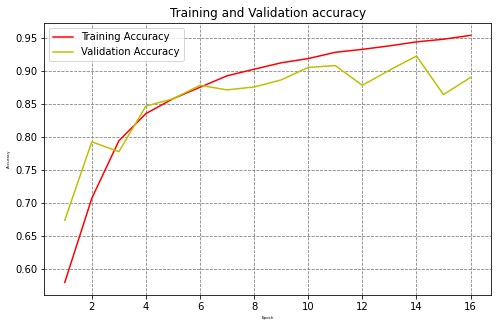

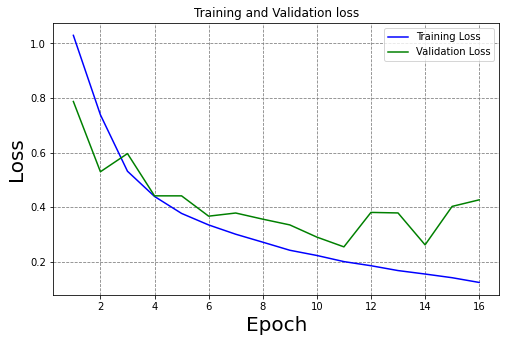

In [32]:
plot_accuracy_graph(n_epochs_vgg,r_vgg)
plot_loss_graph(n_epochs_vgg,r_vgg)

In [33]:
X_train,y_train = extract_from_generator(train_data)
X_test,y_test = extract_from_generator(val_data)
y_pred  = np.round(model_vgg.predict(X_test))
y_test_c = np.argmax(y_test,axis = 1) 
y_pred_c = np.argmax(y_pred,axis = 1)

print(classification_report(y_test,y_pred))

100%|██████████| 197/197 [00:22<00:00,  8.66it/s]


198/198 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      1084
           1       0.87      0.91      0.89      1800
           2       0.94      0.92      0.93      3050
           3       0.92      0.93      0.92       402

   micro avg       0.92      0.90      0.91      6336
   macro avg       0.92      0.90      0.91      6336
weighted avg       0.92      0.90      0.91      6336
 samples avg       0.90      0.90      0.90      6336



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Inception V3

In [36]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import RMSprop
def iv3_model(train_data,test_data, epochs,size):
#Building the model using Keras functional API
    print("----Building the model----")
    
    base_model = InceptionV3(input_shape= (size,size,1), weights = None, include_top=False)
#     base_model.trainable=False #freezing the layer


    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out=Dense(4,activation='softmax')(x)

    model_iv3=Model(inputs=base_model.input,outputs=out) 
    model_iv3.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model_iv3.compile(optimizer= RMSprop(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('iv3_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model_iv3.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model_iv3.evaluate(train_data))
    print("Test score:", model_iv3.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model_iv3,n_epochs

In [37]:
epochs = 25
r_iv3,model_iv3,n_epochs_iv3 = iv3_model(train_data, val_data,epochs,128)

----Building the model----
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_97 (Conv2D)             (None, 63, 63, 32)   288         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_95 (BatchN  (None, 63, 63, 32)  96          ['conv2d_97[0][0]']              
 ormalization)                                                                                    
                                                                 

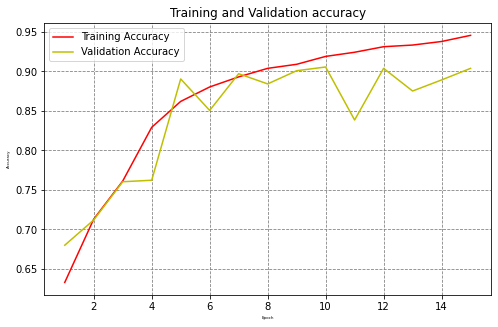

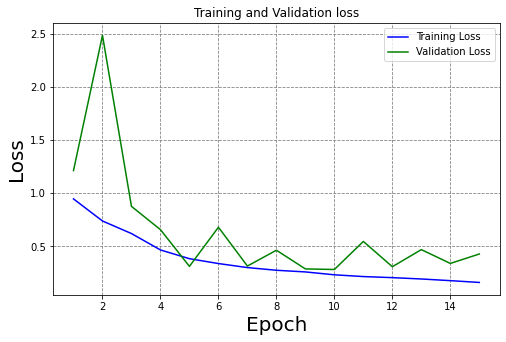

In [38]:
plot_accuracy_graph(n_epochs_iv3,r_iv3)
plot_loss_graph(n_epochs_iv3,r_iv3)

In [39]:
X_train,y_train = extract_from_generator(train_data)
X_test,y_test = extract_from_generator(val_data)
y_pred  = np.round(model_iv3.predict(X_test))
y_test_c = np.argmax(y_test,axis = 1) 
y_pred_c = np.argmax(y_pred,axis = 1)

print(classification_report(y_test,y_pred))

100%|██████████| 197/197 [00:23<00:00,  8.53it/s]


198/198 [==============================] - 4s 14ms/step
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1082
           1       0.93      0.83      0.88      1801
           2       0.90      0.96      0.93      3050
           3       0.94      0.83      0.88       403

   micro avg       0.91      0.90      0.91      6336
   macro avg       0.92      0.87      0.89      6336
weighted avg       0.91      0.90      0.90      6336
 samples avg       0.90      0.90      0.90      6336



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Curves for all the models together

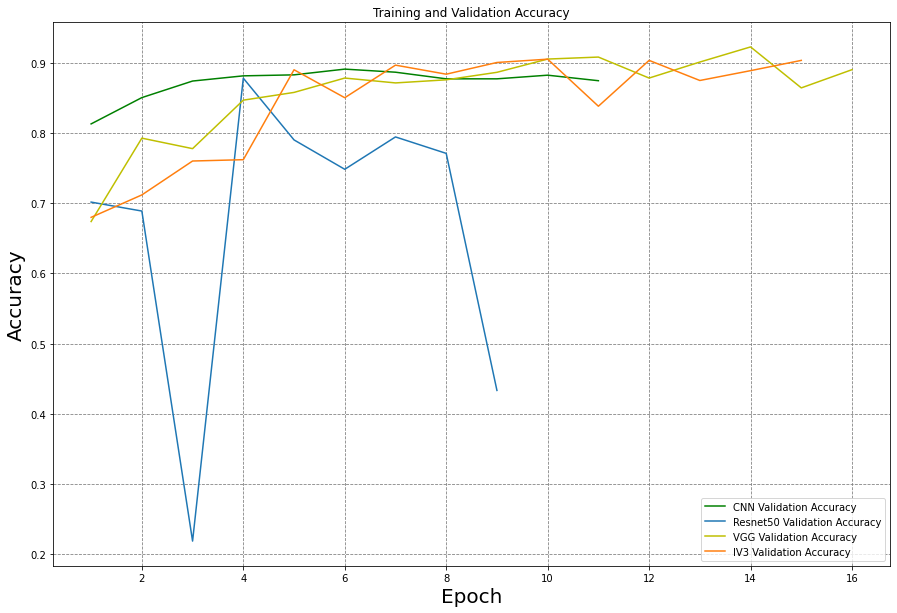

In [40]:
# Validation Accuracy
range_epoch_cnn = range(1,n_epochs_cnn+1)
range_epoch_resnet = range(1,n_epochs_resnet+1)
range_epoch_vgg = range(1,n_epochs_vgg+1)
range_epoch_iv3 = range(1,n_epochs_iv3+1)
fig, ax = plt.subplots(1,1,figsize=(15,10))
ax.plot(range_epoch_cnn,r_cnn.history['val_accuracy'],'g',label = 'CNN Validation Accuracy')
ax.plot(range_epoch_resnet,r_resnet.history['val_accuracy'],label = 'Resnet50 Validation Accuracy')
ax.plot(range_epoch_vgg,r_vgg.history['val_accuracy'],'y',label = 'VGG Validation Accuracy')
ax.plot(range_epoch_iv3,r_iv3.history['val_accuracy'],label = 'IV3 Validation Accuracy')
ax.set_title('Training and Validation Accuracy')
ax.set_xlabel('Epoch', fontsize = 20)
ax.set_ylabel('Accuracy', fontsize = 20)
ax.legend()
ax.grid(color='gray', linestyle='--')

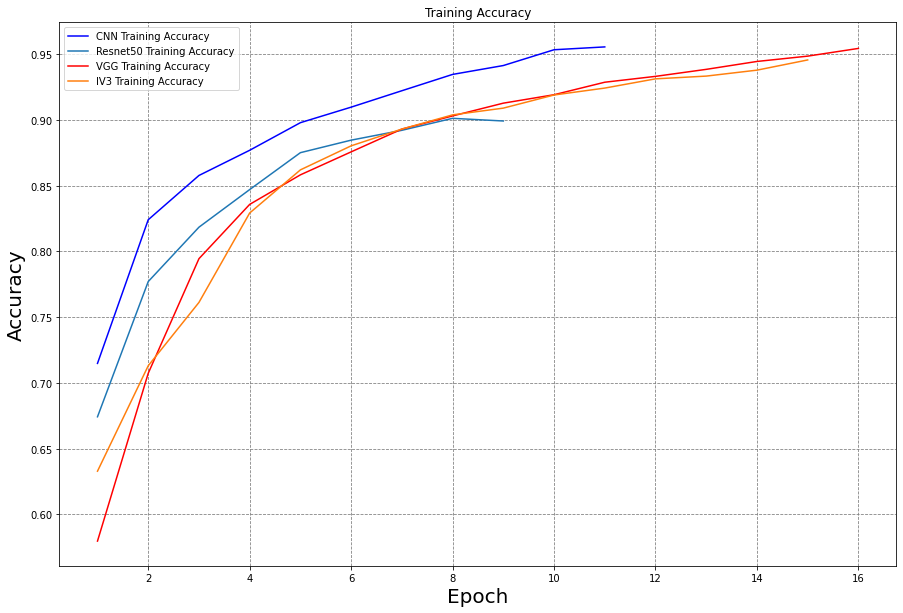

In [41]:
range_epoch_cnn = range(1,n_epochs_cnn+1)
range_epoch_resnet = range(1,n_epochs_resnet+1)
range_epoch_vgg = range(1,n_epochs_vgg+1)
range_epoch_iv3 = range(1,n_epochs_iv3+1)
fig, ax = plt.subplots(1,1,figsize=(15,10))
ax.plot(range_epoch_cnn,r_cnn.history['accuracy'],'b',label = 'CNN Training Accuracy')
ax.plot(range_epoch_resnet,r_resnet.history['accuracy'],label = 'Resnet50 Training Accuracy')
ax.plot(range_epoch_vgg,r_vgg.history['accuracy'],'r',label = 'VGG Training Accuracy')
ax.plot(range_epoch_iv3,r_iv3.history['accuracy'],label = 'IV3 Training Accuracy')
ax.set_title('Training Accuracy')
ax.set_xlabel('Epoch', fontsize = 20)
ax.set_ylabel('Accuracy', fontsize = 20)
ax.legend()
ax.grid(color='gray', linestyle='--')

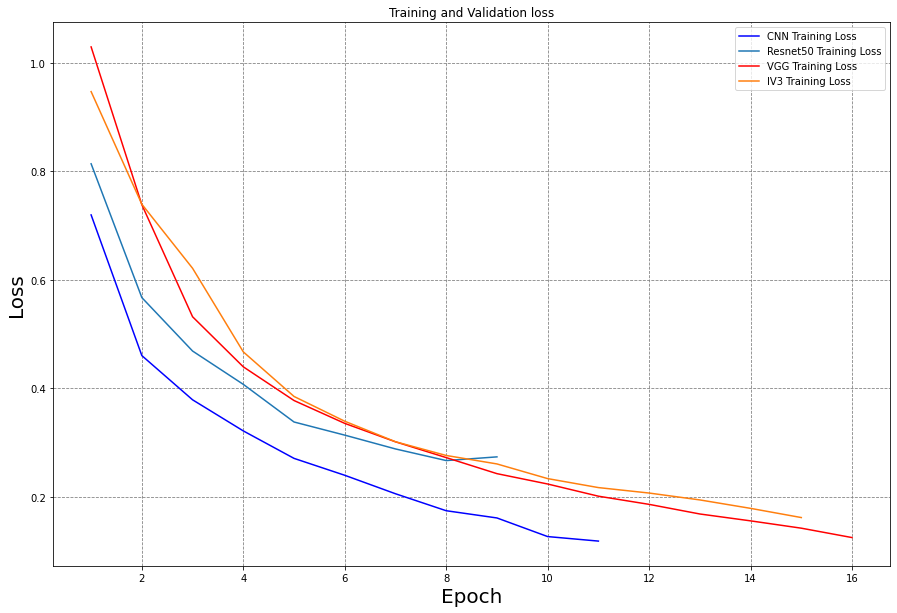

In [42]:
# Training Loss
range_epoch_cnn = range(1,n_epochs_cnn+1)
range_epoch_resnet = range(1,n_epochs_resnet+1)
range_epoch_vgg = range(1,n_epochs_vgg+1)
range_epoch_iv3 = range(1,n_epochs_iv3+1)
fig, ax = plt.subplots(1,1,figsize=(15,10))
ax.plot(range_epoch_cnn,r_cnn.history['loss'],'b',label = 'CNN Training Loss')
ax.plot(range_epoch_resnet,r_resnet.history['loss'],label = 'Resnet50 Training Loss')
ax.plot(range_epoch_vgg,r_vgg.history['loss'],'r',label = 'VGG Training Loss')
ax.plot(range_epoch_iv3,r_iv3.history['loss'],label = 'IV3 Training Loss')
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epoch', fontsize = 20)
ax.set_ylabel('Loss', fontsize = 20)
ax.legend()
ax.grid(color='gray', linestyle='--')

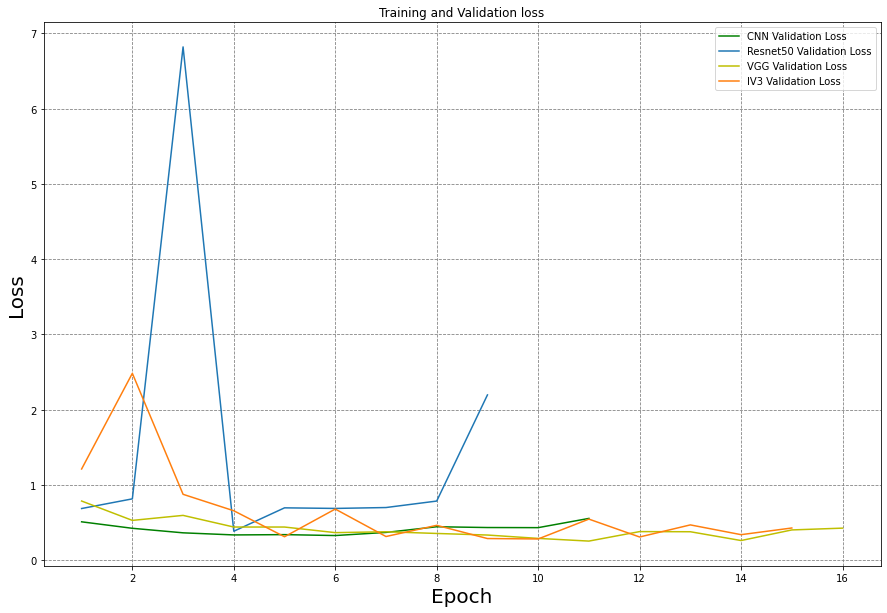

In [43]:
#Validation Loss
range_epoch_cnn = range(1,n_epochs_cnn+1)
range_epoch_resnet = range(1,n_epochs_resnet+1)
range_epoch_vgg = range(1,n_epochs_vgg+1)
range_epoch_iv3 = range(1,n_epochs_iv3+1)
fig, ax = plt.subplots(1,1,figsize=(15,10))
ax.plot(range_epoch_cnn,r_cnn.history['val_loss'],'g',label = 'CNN Validation Loss')
ax.plot(range_epoch_resnet,r_resnet.history['val_loss'],label = 'Resnet50 Validation Loss')
ax.plot(range_epoch_vgg,r_vgg.history['val_loss'],'y',label = 'VGG Validation Loss')
ax.plot(range_epoch_iv3,r_iv3.history['val_loss'],label = 'IV3 Validation Loss')
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epoch', fontsize = 20)
ax.set_ylabel('Loss', fontsize = 20)
ax.legend()
ax.grid(color='gray', linestyle='--')

In [ ]:
# plot_model(model, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(model_resnet, to_file='model_res_plot.png', show_shapes=True, show_layer_names=True)